In [1]:
from stylelib import *
from process_helper import *

In [2]:
path = "/Users/scarlet/Downloads/Sundial-Private/outputs/"
paper_path = "revision/"
storage = "redis"
selectby = "median"
unit = "ms"

## 0. Select Color Scheme

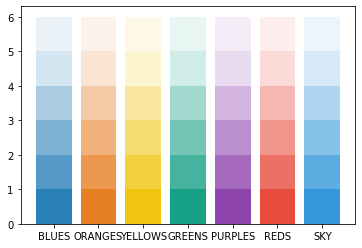

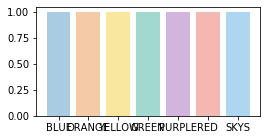

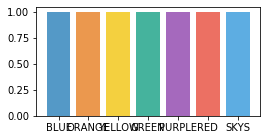

<Figure size 288x144 with 0 Axes>

In [3]:
_, grad_colors = display_colors()
_, bar_colors = select_color_idx(2)
_, line_colors = select_color_idx(4)

In [4]:
C_1PC

'ORANGE'

In [5]:
C_2PC

'BLUE'

In [6]:
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5

## TPCC - WH

In [8]:
exp = "%s_wh"%storage
x = "NUM_WH"
# dfs = [pd.read_csv(path+"tpcc_{}_concat.csv".format(storage, i)) for i in ["_repeated"]]
# df = concat(dfs)
df = pd.read_csv(path+"tpcc_{}.csv".format(storage))
df = apply_mask(df, [("NUM_WH", 1, "ne")])
# agg: "latency" or "Throughput"
agg_throughput, agg_latency = aggregate(x, df, latency_type="dist_latency", agg="latency", how=selectby)
agg_single_latency = process_latency(x, df, latency_type="single_part_latency", select=agg_latency)
agg_multi_latency = process_latency(x, df, latency_type="multi_part_latency", select=agg_latency)

selected trial with median AGG_average_dist_latency


### 2) Latency

In [21]:
def plot_latency(x, data, ys=y_agg_latency, fig=None, ax=None, xlabel="", prefix=PREFIX, ylim=1.5, 
                 line_colors=BLUES, width=5, unit="ms", ylim_speedup=1.5, 
                 plot_speedup=False, speedup_format="text", speedup_yspace=5, speedup_xspace=-1,
                 categorical=False, categorical_data=None):
    linestyle = ["-", "--"] # avg, tail
    if fig is None:
        fig, ax = plt.subplots()
    marker = ["^", "o"] # 1pc, 2pc
    color = [line_colors[C_1PC], line_colors[C_2PC]]
    alglabel = ["Cornus", "2PC"]
    scale = 1
    if unit == "ms":
        scale = 1000
    elif unit == "us":
        scale = 1000000    
    ymax = 0
    if categorical:
        xdata = range(len(categorical_data))
        order_mapping = {}
        for i, v in enumerate(categorical_data):
            order_mapping[v] = i
        data["order"] = data[x].apply(lambda x: order_mapping[x])
        data = data.sort_values(by="order")
    else:
        xdata = x
        data = data.sort_values(by=x)
    for i, alg in enumerate(["ONE_PC", "TWO_PC"]):
        y_data = data[data['COMMIT_ALG'] == alg]
        # sort y_data by specific order
        for j, y in enumerate(ys):
            # default unit is second
            y_data[prefix+y] = y_data[prefix+y] * scale
            ymax = max(y_data[prefix+y].max(), ymax)
            ax.plot(xdata, prefix+y, marker=marker[i], data=y_data, linestyle=linestyle[j], 
                    label=alglabel[i] + " "+ y.replace('_',' '), color=color[i])
    ax.legend(["Cornus avg", "Cornus 99%", "2PC avg", "2PC 99%"],
              loc='upper left', ncol=1, labelspacing=0.1, prop={'size': 14},
              columnspacing=0, handletextpad=0.1, frameon=False, bbox_to_anchor=(-0.01,1.05))
    ax.set_ylim([0, ymax*ylim])
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Txn Latency ({})".format(unit))
    if categorical:
        ax.set_xticklabels([""]+categorical_data)
    plt.grid(axis='y', linestyle='--', linewidth=0.35)
    fig.set_size_inches(5, 2.8)
    if plot_speedup:
        twopc = apply_mask(data, [("COMMIT_ALG", "TWO_PC")])[prefix+ys[0]].values * scale
        onepc = apply_mask(data, [("COMMIT_ALG", "ONE_PC")])[prefix+ys[0]].values * scale
        speedup = twopc / onepc
        print("speedup: {}".format(speedup))
        if not categorical:
            x_data = data[x].unique()
        else:
            x_data = xdata
        if speedup_format == "text":
            for x, y, s in zip(x_data, twopc, speedup):
                ax.text(x + speedup_xspace, y + speedup_yspace, "%.1fx"%(s), fontsize=12)
            return fig, ax, None
        else:
            ax2 = ax.twinx()
            ax2_legend = "Speedup in avg latency"
            ax2_name = "Speedup of 1PC \nw.r.t. 2PC"
            ax2.bar(data[x].unique(), y_data, width=width, color=tuple(list(GREYS[0])[:3]+[0.5]))
            ax2.set_ylim(0, y_data.max() * ylim_speedup)
            ax2.legend([ax2_legend], loc="upper left", prop={'size': 14}, bbox_to_anchor=(-0.015,1.2), frameon=False)
            ax2.set_ylabel(ax2_name)
            ax2.set_xticks(data[x].unique())
            return fig, ax, ax2
    return fig, ax

/Users/scarlet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


speedup: [1.67604797 1.86496221 1.52074719]


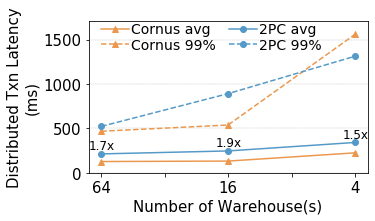

In [31]:
data = agg_latency.sort_values(by=x)
fig, ax, ax2 = plot_latency(x, data, ys=y_agg_dist_latency, 
                            xlabel="Number of Warehouse(s)",
                            plot_speedup=True, speedup_yspace=50, speedup_xspace=-0.1,
                            line_colors=line_colors, ylim=1.1, unit="ms", categorical=True, 
                            categorical_data=[64,16,4])
ax.legend(["Cornus avg", "Cornus 99%", "2PC avg", "2PC 99%"], loc='upper left', 
          ncol=2, prop={'size': 14}, labelspacing=0.1, columnspacing=1, handletextpad=0.1, frameon=False,
          bbox_to_anchor=(0,1.07))
ax.set_ylabel("Distributed Txn Latency\n(%s)"%unit)
ax.set_xticklabels(["",64,"",16,"",4])
# plt.yscale("log")
# plt.ylim((1,10000))
plt.savefig(paper_path+exp+"_latency_({}_latency).pdf".format(selectby), bbox_inches="tight")

### 3) breakdown

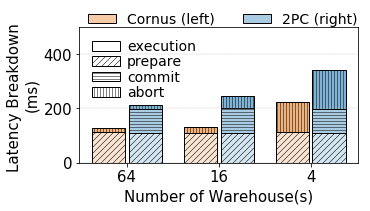

In [34]:
xcate = [64, 16, 4]
zipper = zip(xcate, [y_multi_part_latency]*len(xcate))
fig, ax = plot_breakdown(x, zipper, xcate, bar_colors, grad_colors, how=None, agg_multi_latency=agg_multi_latency)
plt.xticks(np.array([0, 0.5, 1]), xcate)
plt.ylim((0, 500))
#ax.set_yscale('log')
ax.set_xlabel("Number of Warehouse(s)")
plt.savefig(paper_path+exp+"_breakdown_({}_latency).pdf".format(selectby), bbox_inches="tight")